In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/asl_dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


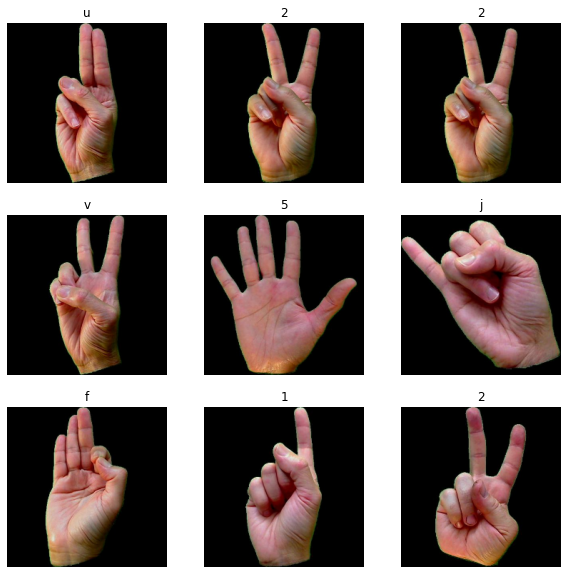

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation

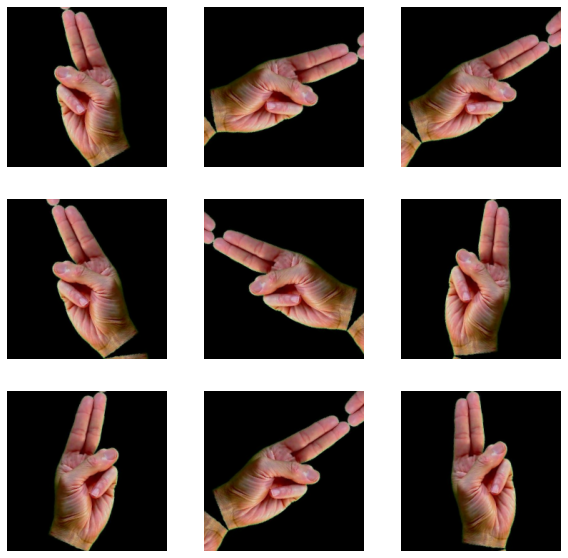

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

reshape_2
predictions


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n03485794', 'handkerchief', 0.11913438),
  ('n04033901', 'quill', 0.091092184)],
 [('n03929660', 'pick', 0.31871086), ('n02786058', 'Band_Aid', 0.15124011)],
 [('n02786058', 'Band_Aid', 0.44052678), ('n03793489', 'mouse', 0.15949257)],
 [('n02786058', 'Band_Aid', 0.89896506), ('n01776313', 'tick', 0.010744355)],
 [('n02786058', 'Band_Aid', 0.5675772), ('n03929660', 'pick', 0.11188383)],
 [('n12267677', 'acorn', 0.35603738), ('n01955084', 'chiton', 0.32856488)],
 [('n02786058', 'Band_Aid', 0.41308212), ('n03929660', 'pick', 0.06473812)],
 [('n02786058', 'Band_Aid', 0.41228083), ('n09229709', 'bubble', 0.04743081)],
 [('n02786058', 'Band_Aid', 0.40557188), ('n03929660', 'pick', 0.38318077)],
 [('n02786058', 'Band_Aid', 0.21294779),
  ('n01930112', 'nematode', 0.07291688)],
 [('n02786058', 'Band_Aid', 0.35449746), ('n03929660', 'pick', 0.08105761)],
 [('n02786058', 'Band_Aid', 0.23419943),
  ('n03250847', 'drumstick', 0.22939773)],
 [('n02786058', 'Band_Aid', 0.89346576),
  ('n0325084

In [ ]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=input_shape,
                                                   include_top=False, #removes the top level layers; output layers
                                                   weights='imagenet') # From imageNet
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x, training=False) 
  x = tfl.Flatten()(x)
  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model

In [ ]:
model = asl_model(IMG_SIZE, data_augmentation)


In [ ]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [ ]:
lr = 0.01
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [23]:
initial_epochs = 50
with tf.device('/device:GPU:1'):
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 669s 12s/step - loss: 7.0808 - accuracy: 0.4946 - val_loss: 3.5856 - val_accuracy: 0.7202
Epoch 2/50
56/56 [==============================] - 6s 102ms/step - loss: 3.1679 - accuracy: 0.7689 - val_loss: 4.0581 - val_accuracy: 0.7427
Epoch 3/50
56/56 [==============================] - 6s 103ms/step - loss: 2.0723 - accuracy: 0.8330 - val_loss: 2.2513 - val_accuracy: 0.7878
Epoch 4/50
56/56 [==============================] - 6s 104ms/step - loss: 1.3960 - accuracy: 0.8694 - val_loss: 2.2375 - val_accuracy: 0.8329
Epoch 5/50
56/56 [==============================] - 7s 119ms/step - loss: 1.2836 - accuracy: 0.8847 - val_loss: 1.8595 - val_accuracy: 0.8767
Epoch 6/50
56/56 [==============================] - 6s 105ms/step - loss: 1.5891 - accuracy: 0.8773 - val_loss: 3.7324 - val_accuracy: 0.7785
Epoch 7/50
56/56 [==============================] - 6s 104ms/step - loss: 1.4091 - accuracy: 0.9012 - val_loss: 1.2493 - val_accuracy: 0.8833
Epoch 

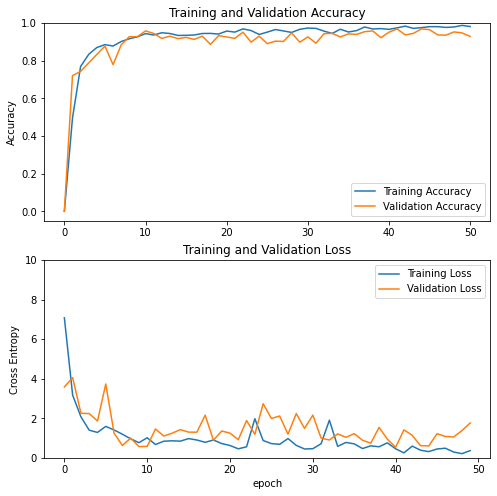

Highest Accuracy: 98.69392514228821%
Highest Validation Accuracy: 96.81697487831116%


In [27]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
print('Highest Accuracy: {}%'.format(max(history.history['accuracy'])*100))
print('Highest Validation Accuracy: {}%'.format(max(history.history['val_accuracy'])*100))

In [28]:
model.save('/content/drive/MyDrive/Trained Models/MobileNet')